# Investigating Song Addition Dates
Let's first explore whether Spotify's shuffle modes exhibit any pattern regarding how recently a song was added to a playlist. Do newer songs tend to play more frequently? Older songs? Or does the distribution appear to be uniform?

In [1]:
# Imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chisquare
import numpy as np
import random
from collections import Counter
import os

# Load data
df_shuffle = pd.read_csv('../data/shuffle_playthrough.csv', index_col=0)
df_smart_shuffle = pd.read_csv('../data/smart_shuffle_playthrough.csv')
df_shuffle.head()

# Constants
NUM_BINS = 30
sns.set_theme()

## Distributions

### Normal Shuffle

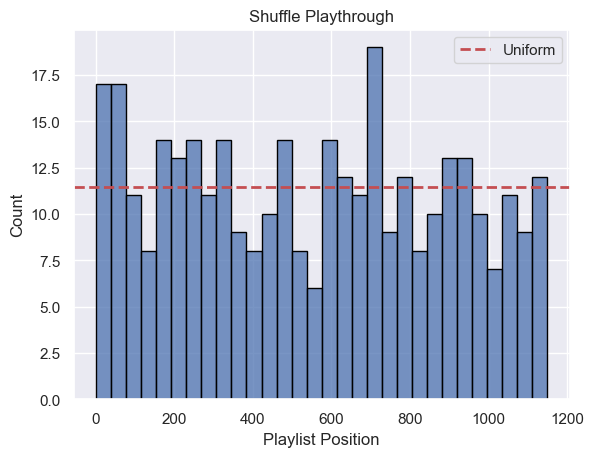

In [278]:
# Distribution of shuffle playthrough
freq_shuffle, bins_shuffle = np.histogram(df_shuffle['playlist_pos'], bins=NUM_BINS)
sns.histplot(df_shuffle, x='playlist_pos', bins=bins_shuffle, ec='black')
plt.title('Shuffle Playthrough')
plt.xlabel('Playlist Position')
uniform_avg_shuffle = len(df_shuffle) / NUM_BINS
plt.axhline(y = uniform_avg_shuffle, color = 'r', lw=2, linestyle = '--', label='Uniform')
plt.legend()
plt.show()

### Smart Shuffle

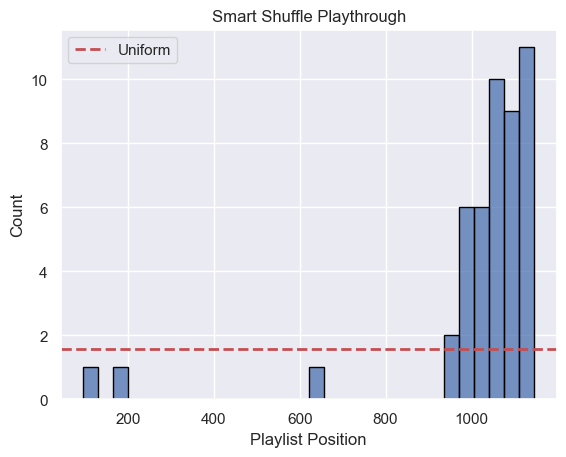

In [279]:
# Distribution of smart shuffle playthrough
freq_smart_shuffle, bins_smart_shuffle = np.histogram(df_smart_shuffle['playlist_pos'], bins=NUM_BINS)
sns.histplot(df_smart_shuffle, x='playlist_pos', bins=bins_smart_shuffle, ec='black')
plt.title('Smart Shuffle Playthrough')
plt.xlabel('Playlist Position')
uniform_avg_smart_shuffle = len(df_smart_shuffle) / NUM_BINS
plt.axhline(y = uniform_avg_smart_shuffle, color = 'r', lw=2, linestyle = '--', label='Uniform')
plt.legend()
plt.show()

## Hypothesis Testing
As we see above, the normal shuffle mode appears to be roughly uniform, while the smart shuffle isn't remotely uniform (instead heavily favoring recently added songs). Let's be statistically rigorous and do some hypothesis testing. In particular, we'll perform a Chi Square goodness of fit test to see if the distributions are indeed uniform or not.

### Normal Shuffle

In [188]:
expected_freq = [uniform_avg_shuffle for _ in range(NUM_BINS)]
chi2_stat, p_value = chisquare(freq_shuffle, f_exp=expected_freq)
print('Hypotheses\n----------')
print('H_0: Shuffle mode is uniformly distributed (in terms of date added).')
print('H_A: Shuffle mode is not uniformly distributed (in terms of date added).')
print(f'\np-value = {round(p_value, 4)}')
print("\nBecause our p-value is greater than any reasonable level of significance (e.g. 0.05), we fail to reject the null hypothesis.\n" + 
      "That is, we do not have sufficient evidence to conclude that Spotify's shuffle mode is not uniformly distributed.")

Hypotheses
----------
H_0: Shuffle mode is uniformly distributed (in terms of date added).
H_A: Shuffle mode is not uniformly distributed (in terms of date added).

p-value = 0.7016

Because our p-value is greater than any reasonable level of significance (e.g. 0.05), we fail to reject the null hypothesis.
That is, we do not have sufficient evidence to conclude that Spotify's shuffle mode is not uniformly distributed.


### Smart Shuffle

In [189]:
expected_freq = [uniform_avg_smart_shuffle for _ in range(NUM_BINS)]
chi2_stat, p_value = chisquare(freq_smart_shuffle, f_exp=expected_freq)
print('Hypotheses\n----------')
print('H_0: Smart shuffle mode is uniformly distributed (in terms of date added).')
print('H_A: Smart shuffle mode is not uniformly distributed (in terms of date added).')
print(f'\np-value = {round(p_value, 4)}')
print("\nBecause our p-value is less than any reasonable level of significance (e.g. 0.05), we reject the null hypothesis.\n" + 
      "That is, we have sufficient evidence to conclude that Spotify's smart shuffle mode is not uniformly distributed.")

Hypotheses
----------
H_0: Smart shuffle mode is uniformly distributed (in terms of date added).
H_A: Smart shuffle mode is not uniformly distributed (in terms of date added).

p-value = 0.0

Because our p-value is less than any reasonable level of significance (e.g. 0.05), we reject the null hypothesis.
That is, we have sufficient evidence to conclude that Spotify's smart shuffle mode is not uniformly distributed.


# Investigating Number of Repeated Songs
Next, we're going to play through a certain number of songs on shuffle over and over again and look at the number of repeated songs we had. If the samples were truly random, what would the distribution of repeated songs look like? What does our observed distribution look like?

## Monte Carlo Simulation
Let's first look at what the distribution should look like if the shuffle were truly random. We will simulate playing 20% of a playlist on a **truly random** shuffle mode 50 times and count the number of repeated songs we find. We're going to do this 10,000 times and average the results.

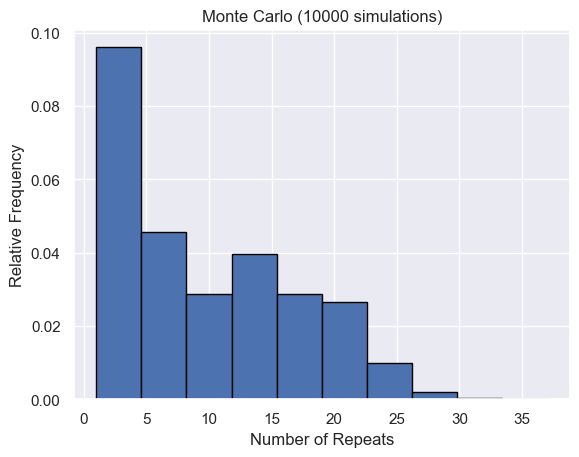

In [77]:
def generate_random_samples(N, n):
    """ Generate N random samples of size n from numbers 1 to 141 (inclusive) """
    samples = [random.sample(range(1, 142), n) for _ in range(N)]
    return samples

def count_repeats(samples):
    """ Counts number of times each integer occurs across all samples. """
    flattened_samples = [num for sample in samples for num in sample]
    counts = Counter(flattened_samples)
    return counts

# Simulation constants
M = 10000
N = 50
n = int(141 * 0.2)

# Find average distribution of number of repeats
simulated_repeat_count_freq = []
for _ in range(M):
    samples = generate_random_samples(N, n)
    repeat_counts = list(count_repeats(samples).values())
    repeat_count_freq = list(Counter(repeat_counts).values())
    simulated_repeat_count_freq += repeat_count_freq

# Plot
plt.hist(simulated_repeat_count_freq, ec='black', density=True)
plt.xlabel('Number of Repeats')
plt.ylabel('Relative Frequency')
plt.title(f'Monte Carlo ({M} simulations)')
plt.show()

## Observed Data
Next, let's actually do what a simulation above represented. We will play 20% of a playlist using Spotify's shuffle mode 50 times and count the number of repeated songs we find.

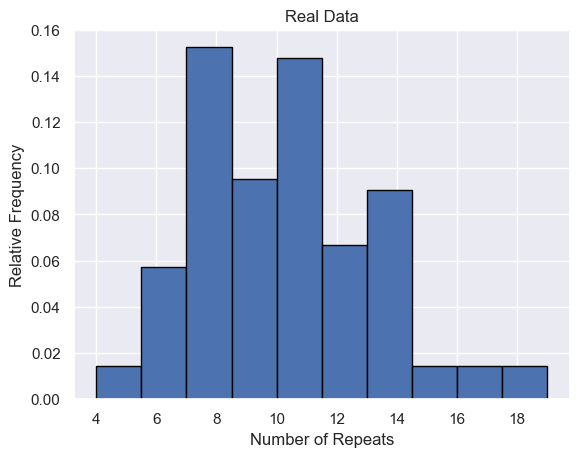

In [68]:
# Read all playthrough data
directory_path = '../data/monte-carlo-playthroughs/'
filenames = [file for file in os.listdir(directory_path) if file.endswith('.csv')]
df_total = pd.DataFrame()
for file in filenames:
    file_path = os.path.join(directory_path, file)
    df = pd.read_csv(file_path, index_col=0)
    df_total = pd.concat([df_total, df])

# Find observed number of repeats
df_total['row_tuple'] = df_total.apply(tuple, axis=1)
repeat_counts = list(df_total['row_tuple'].value_counts())

# Plot
plt.hist(repeat_counts, ec='black', density=True)
plt.xlabel('Observed Number of Repeats')
plt.ylabel('Relative Frequency')
plt.title('Real Data')
plt.show()

## Hypothesis Testing
Clearly, these distributions look different. But let's again be rigorous and perform a hypothesis test. We'll do another Chi Square goodness of fit test to see how probable it is that our observed data came from the (truly random) Monte Carlo simulated distribution.

In [78]:
def calculate_percentage_occurrence(lst):
    """ Returns a dictionary representing the probabilistic distribution of each integer. """
    total_elements = len(lst)
    occurrences = {}
    for num in lst:
        occurrences[num] = occurrences.get(num, 0) + 1
    percentages = {num: (count / total_elements) for num, count in occurrences.items()}
    return percentages

# Prepare expecting vs. observed distributions
expected_dist = calculate_percentage_occurrence(simulated_repeat_count_freq)
observed_dist = Counter(repeat_counts)
for key in expected_dist.keys():
    expected_dist[key] *= len(repeat_counts)
    if not key in observed_dist.keys():
        observed_dist[key] = 0

chi2_stat, p_value = chisquare(list(observed_dist.values()), f_exp=list(expected_dist.values()))
print('Hypotheses\n----------')
print('H_0: The observed number of repeated songs came from the (truly random) Monte Carlo distribution.')
print('H_A: The observed number of repeated songs did NOT come from the (truly random) Monte Carlo distribution.')
print(f'\np-value = {round(p_value, 4)}')
print("\nBecause our p-value is less than any reasonable level of significance (e.g. 0.05), we reject the null hypothesis.\n" + 
      "That is, we have sufficient evidence to conclude that the number of repeated songs did NOT come from the (truly random) Monte Carlo distribution.\n" + 
      "This in turn implies that Spotify's shuffle mode is extremely unlikely to be truly random (as in the Monte Carlo simulations).")

Hypotheses
----------
H_0: The observed number of repeated songs came from the (truly random) Monte Carlo distribution.
H_A: The observed number of repeated songs did NOT come from the (truly random) Monte Carlo distribution.

p-value = 0.0

Because our p-value is less than any reasonable level of significance (e.g. 0.05), we reject the null hypothesis.
That is, we have sufficient evidence to conclude that the number of repeated songs did NOT come from the (truly random) Monte Carlo distribution.
This in turn implies that Spotify's shuffle mode is extremely unlikely to be truly random (as in the Monte Carlo simulations).


# Final Notes
- Spotify's shuffle mode is already known not to be random, and this is on purpose. For example, it spreads out songs of a certain artist. Spotify used to used a actual random shuffle before 2014 (an algorithm called *Fish-Yates shuffle*), but it found that their users preferred their new approach as the listening session felt more diverse and fresh.
- On the other hand, the "Smart Shuffle" is not even making an attempt to be pseudo-random, and I don't know why. When new songs aren't being suggested, it will mainly play songs that have been recently added. This is probably because it either has some bias towards recency or listening habits (combined with the fact that I listen to my recently added songs more than older songs). In either case, I think this feature would be much more enjoyable if it used the default shuffling algorithm with the song suggestions being interjected every few songs.